In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set up a consistent plot style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# --- System Parameters (from the table) ---

Ca_in = 1.0       # mol/L
V = 100.0         # L
k0 = 4.11e13      # L/(mol*min)
E = 76534.704     # J/mol
R = 8.314         # J/(mol*K)
T_in = 275.0      # K
neg_dH = 596619  # J/mol (Using the positive value for -ΔH)
rho = 1.0         # kg/L
Cp = 4200.0       # J/(kg*K)
UA = 20000 * 60   # J/(min*K) -> (Assuming 20000 J/s*K from context)
Vw = 10.0         # L
rho_w = 1.0       # kg/L
Cpw = 4200.0      # J/(kg*K)
Tj_in = 250.0     # K
Fws = 30.0        # L/min

Time-Varying Input $u(t)$

In [ ]:
#Time-Varying Input Function u(t) = F(t)
def get_u(t):
    
    if 0 <= t < 4:
        return 100.0  # L/min
    elif 4 <= t < 12:
        return 80.0   # L/min
    else:
        # This covers 12 <= t <= 20
        return 120.0  # L/min

ODE System Definition

In [4]:
# --- Core ODE System Definition ---
def F_system(x, t):
    """
    Defines the system of 3 ODEs: dx/dt = F(x, t)
    x is a 3-element vector: [Ca, T, Tj]
    t is the current time
    """
    # Unpack the state vector
    Ca = x[0]
    T = x[1]
    Tj = x[2]
    
    # Get the current input flow rate
    u_t = get_u(t)
    
    # Calculate the reaction rate constant k(T)
    if T <= 0: # Avoid division by zero
        k = 0.0
    else:
        k = k0 * np.exp(-E / (R * T))
    
    # --- Calculate the rate of change for each state ---
    
    # Equation 1: dCa/dt
    dCa_dt = (u_t / V) * (Ca_in - Ca) - 2 * k * (Ca**2)
    
    # Equation 2: dT/dt
    term1_T = (u_t / V) * (T_in - T)
    term2_T = (2 * neg_dH * k * (Ca**2)) / (rho * Cp)
    term3_T = -(UA * (T - Tj)) / (V * rho * Cp)
    dT_dt = term1_T + term2_T + term3_T
    
    # Equation 3: dTj/dt
    term1_Tj = (Fws / Vw) * (Tj_in - Tj)
    term2_Tj = (UA * (T - Tj)) / (Vw * rho_w * Cpw)
    dTj_dt = term1_Tj + term2_Tj
    
    return np.array([dCa_dt, dT_dt, dTj_dt])

Simulation Setup

In [5]:
# --- Simulation Setup ---
h = 0.01      # min (time step)
t_f = 20.0    # min (final time)
N = int(t_f / h)  # Number of steps
t_span = np.linspace(0, t_f, N + 1) # Time vector

# Initial Condition (steady state x*)
x0 = np.array([0.0192, 384.0056, 371.2721])

# Iteration parameters for Crank-Nicholson
epsilon = 1.0e-6  # Tolerance
k_max = 20        # Max iterations

Solver 1 - Heun's Modified Algorithm

In [6]:
# --- Solver 1: Heun's Modified Algorithm ---
def solve_heun(F_system, x0, t_span, h):
    """Solves the ODE system using Heun's method."""
    print("Running Heun's Method...")
    N = len(t_span) - 1
    # Create an array to store all results
    X_heun = np.zeros((N + 1, len(x0)))
    X_heun[0] = x0
    
    for n in range(N):
        x_n = X_heun[n]
        t_n = t_span[n]
        t_np1 = t_span[n+1]
        
        # Calculate F(n)
        F_n = F_system(x_n, t_n)
        
        # Predictor step (x_tilde)
        x_tilde = x_n + h * F_n
        
        # Corrector step
        F_tilde = F_system(x_tilde, t_np1)
        x_np1 = x_n + (h / 2.0) * (F_n + F_tilde)
        
        X_heun[n + 1] = x_np1
        
    print("Heun's Method complete.")
    return X_heun

Solver 2 - Crank-Nicholson Algorithm

In [ ]:
# --- Solver 2: Crank-Nicholson Algorithm ---
def solve_crank_nicholson(F_system, x0, t_span, h, epsilon, k_max):
    """Solves the ODE system using the iterative Crank-Nicholson method."""
    print("Running Crank-Nicholson Method...")
    N = len(t_span) - 1
    # Create an array to store all results
    X_crank = np.zeros((N + 1, len(x0)))
    X_crank[0] = x0
    
    for n in range(N):
        x_n = X_crank[n]
        t_n = t_span[n]
        t_np1 = t_span[n+1]
        
        # Calculate F(n) (this is constant for the inner loop)
        F_n = F_system(x_n, t_n)
        
        
        # Initial guess using Explicit Euler (x^(0)(n+1))
        x_k = x_n + h * F_n 
        
        k = 1
        delta = 1.0 # Initialize delta to be > epsilon
        
        while (delta > epsilon) and (k < k_max):
            x_k_old = x_k.copy() # Store the previous guess
            
            # F(n+1, x^(k)(n+1))
            F_np1_k = F_system(x_k, t_np1)
            
            # C-N Update (x^(k+1)(n+1))
            x_k_new = x_n + (h / 2.0) * (F_n + F_np1_k)
            
            # Calculate relative error (as per pseudo-code)
            norm_new = np.linalg.norm(x_k_new)
            if norm_new == 0:
                delta = 0 # Avoid division by zero
            else:
                # || x(k+1) - x(k) || / || x(k+1) ||
                delta = np.linalg.norm(x_k_new - x_k_old) / norm_new
                
            x_k = x_k_new # Update guess for next iteration
            k = k + 1
        
        
        X_crank[n + 1] = x_k # Store the converged value
        
    print("Crank-Nicholson complete.")
    return X_crank

Executing  Solvers

In [12]:
# --- Execution ---
# Run both solvers and store the history of states
import time
start = time.time()
X_heun = solve_heun(F_system, x0, t_span, h)

mid  = time.time()

X_crank = solve_crank_nicholson(F_system, x0, t_span, h, epsilon, k_max)

end = time.time()

print(mid-start, end-mid, end-start)

# Calculate the difference (error)
Error = X_crank - X_heun

# Extract individual state variables for plotting
Ca_h, T_h, Tj_h = X_heun[:, 0], X_heun[:, 1], X_heun[:, 2]
Ca_c, T_c, Tj_c = X_crank[:, 0], X_crank[:, 1], X_crank[:, 2]
e_Ca, e_T, e_Tj = Error[:, 0], Error[:, 1], Error[:, 2]

print("All calculations finished. Ready for plotting.")

Running Heun's Method...
Heun's Method complete.
Running Crank-Nicholson Method...
Crank-Nicholson complete.
0.014997005462646484 0.02228856086730957 0.037285566329956055
All calculations finished. Ready for plotting.


Plot 1 - State Variable Comparisons

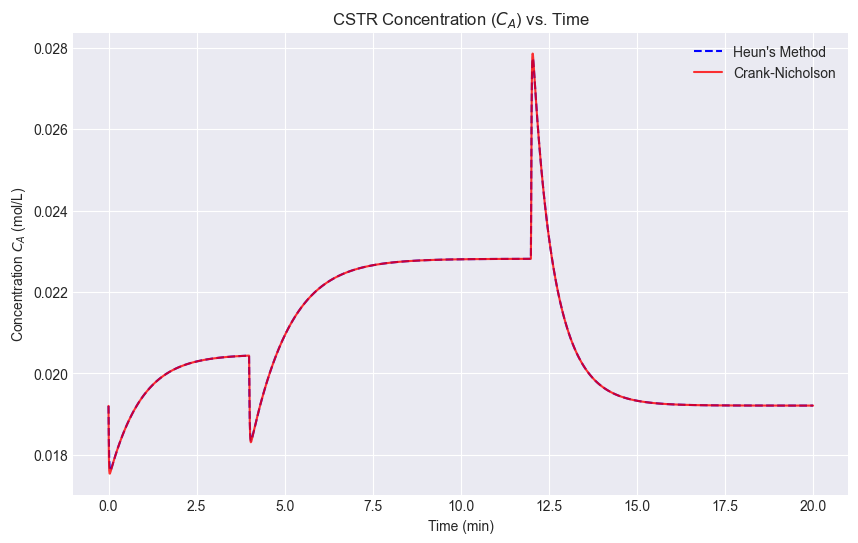

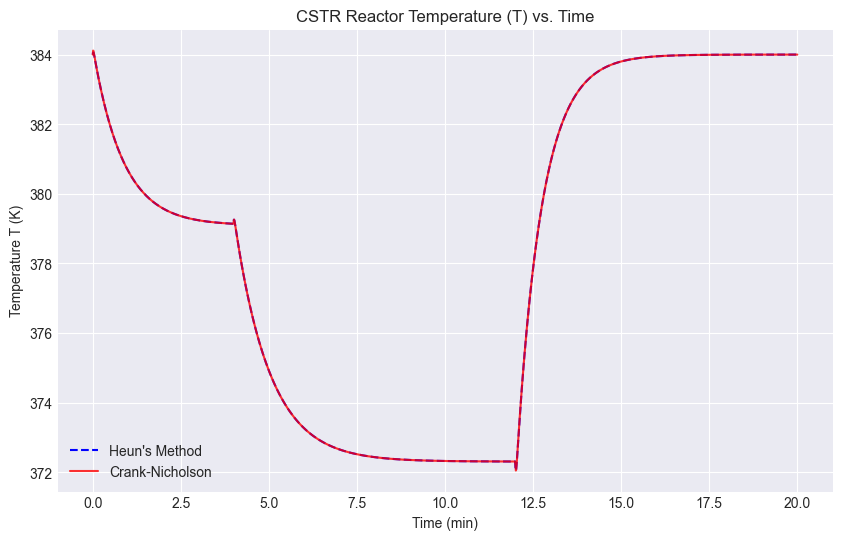

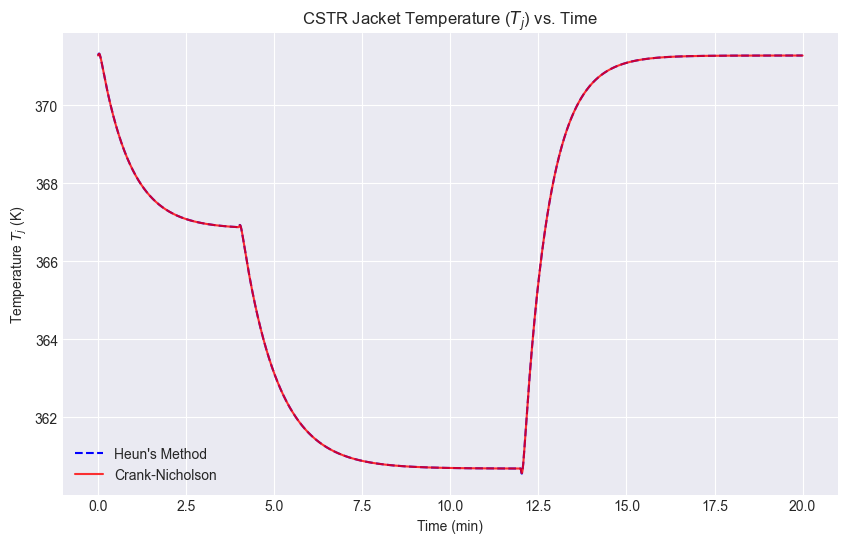

In [9]:
# --- Plotting: State Comparisons ---

# --- Plot 1: Comparison of Ca ---
plt.figure(figsize=(10, 6))
plt.plot(t_span, Ca_h, 'b--', label="Heun's Method")
plt.plot(t_span, Ca_c, 'r-', label="Crank-Nicholson", alpha=0.8)
plt.title('CSTR Concentration ($C_A$) vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('Concentration $C_A$ (mol/L)')
plt.legend()
plt.show()

# --- Plot 2: Comparison of T ---
plt.figure(figsize=(10, 6))
plt.plot(t_span, T_h, 'b--', label="Heun's Method")
plt.plot(t_span, T_c, 'r-', label="Crank-Nicholson", alpha=0.8)
plt.title('CSTR Reactor Temperature (T) vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('Temperature T (K)')
plt.legend()
plt.show()

# --- Plot 3: Comparison of Tj ---
plt.figure(figsize=(10, 6))
plt.plot(t_span, Tj_h, 'b--', label="Heun's Method")
plt.plot(t_span, Tj_c, 'r-', label="Crank-Nicholson", alpha=0.8)
plt.title('CSTR Jacket Temperature ($T_j$) vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('Temperature $T_j$ (K)')
plt.legend()
plt.show()

Plot 2 - Error Plots

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
C:\Users\xabc0\AppData\Local\Temp\ipykernel_321232\3393435141.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Difference ($\epsilon_1$) in $C_A$ (Crank-Nicholson - Heun)')
C:\Users\xabc0\AppData\Local\Temp\ipykernel_321232\3393435141.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\epsilon_1$ (mol/L)')
C:\Users\xabc0\AppData\Local\Temp\ipykernel_321232\33934

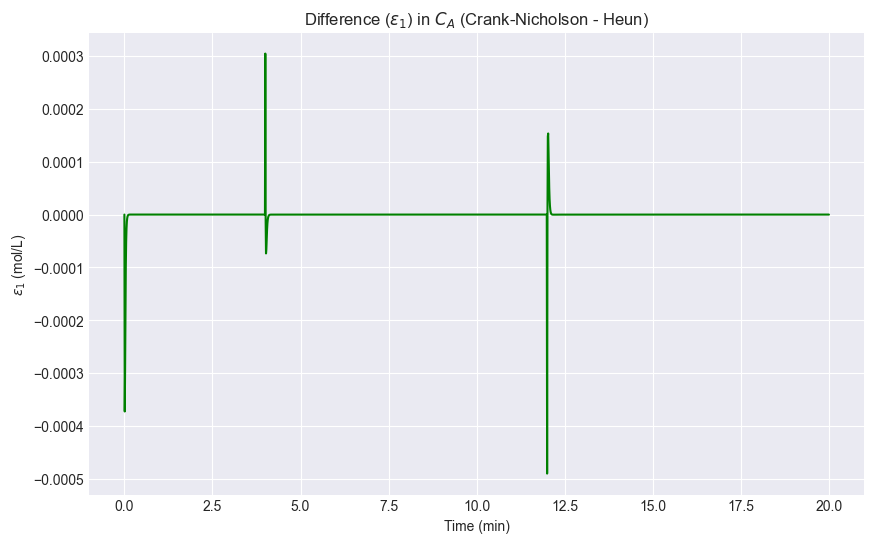

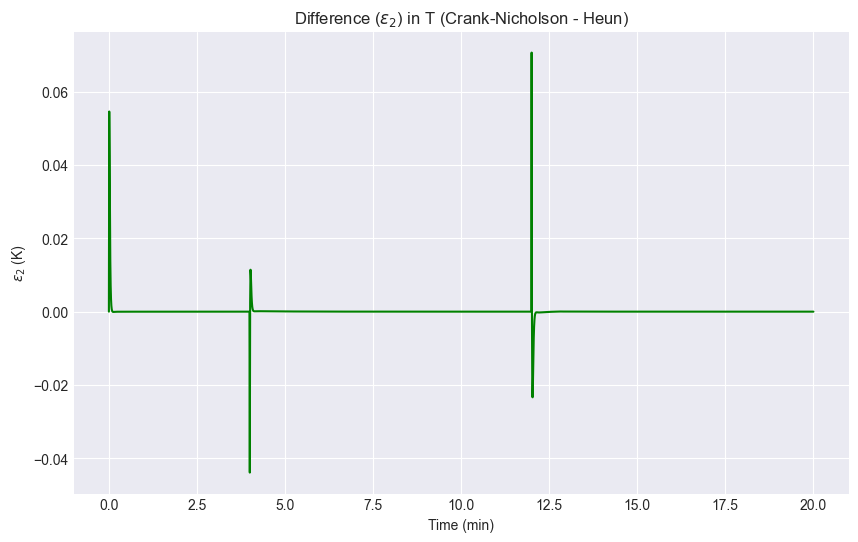

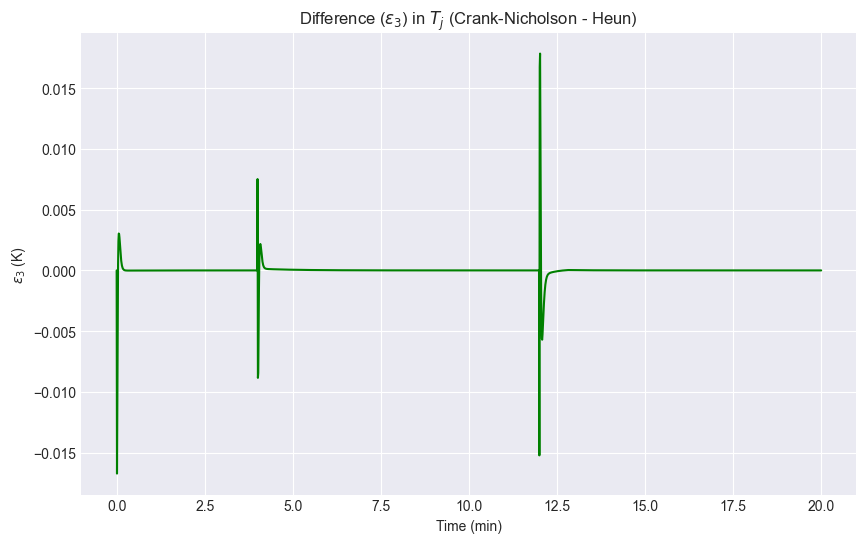

In [10]:
# --- Plotting: Error (Difference) ---

# --- Plot 4: Error in Ca (ε1) ---
plt.figure(figsize=(10, 6))
plt.plot(t_span, e_Ca, 'g-')
plt.title('Difference ($\epsilon_1$) in $C_A$ (Crank-Nicholson - Heun)')
plt.xlabel('Time (min)')
plt.ylabel('$\epsilon_1$ (mol/L)')
plt.show()

# --- Plot 5: Error in T (ε2) ---
plt.figure(figsize=(10, 6))
plt.plot(t_span, e_T, 'g-')
plt.title('Difference ($\epsilon_2$) in T (Crank-Nicholson - Heun)')
plt.xlabel('Time (min)')
plt.ylabel('$\epsilon_2$ (K)')
plt.show()

# --- Plot 6: Error in Tj (ε3) ---
plt.figure(figsize=(10, 6))
plt.plot(t_span, e_Tj, 'g-')
plt.title('Difference ($\epsilon_3$) in $T_j$ (Crank-Nicholson - Heun)')
plt.xlabel('Time (min)')
plt.ylabel('$\epsilon_3$ (K)')
plt.show()